# Efecto de régimen de dosificación en PTA

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from keras.wrappers.scikit_learn import KerasRegressor

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import numpy as np
import pandas as pd

from matplotlib import cm, ticker
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import datasets
from google.colab import files

In [5]:
!pip install eli5
!pip install shap
import eli5
from eli5.sklearn import PermutationImportance
import shap

In [6]:
data = pd.read_csv('evaluacionRegimenes.csv')
data.head()

,DD,II,CLCR,tinf,AUC_target,cmin_target
0,1185.305203,16.382515,122.393621,10.371416,0.000,0.000
1,3541.546326,17.707842,132.087299,10.349899,0.150,0.295
2,1234.332791,6.996703,85.726831,2.071341,0.185,0.030
3,1486.408638,19.810702,133.081308,7.248445,0.045,0.000
4,2659.989257,16.779880,141.393789,15.036658,0.700,0.435


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DD           5000 non-null   float64
 1   II           5000 non-null   float64
 2   CLCR         5000 non-null   float64
 3   tinf         5000 non-null   float64
 4   AUC_target   5000 non-null   float64
 5   cmin_target  5000 non-null   float64
dtypes: float64(6)
memory usage: 234.5 KB


Se seleccionan a las variables `DD`, `ii`, `tinf`, `CLCR`, y `MIC`, como variables dependientes, se conoce por gráficos marginales que `ii`, `tinf`, y `CLCR` aportan poca información sobre el indicador PK-PD reportado en la columna `mn` (AUC/MIC >= 400).

In [8]:
X  = data.loc[:, ['DD', 'II', 'tinf', 'CLCR']]
y1 = data.AUC_target
y2 = data.cmin_target
Y  = np.array([y1.ravel(), y2.ravel()]).T

In [9]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

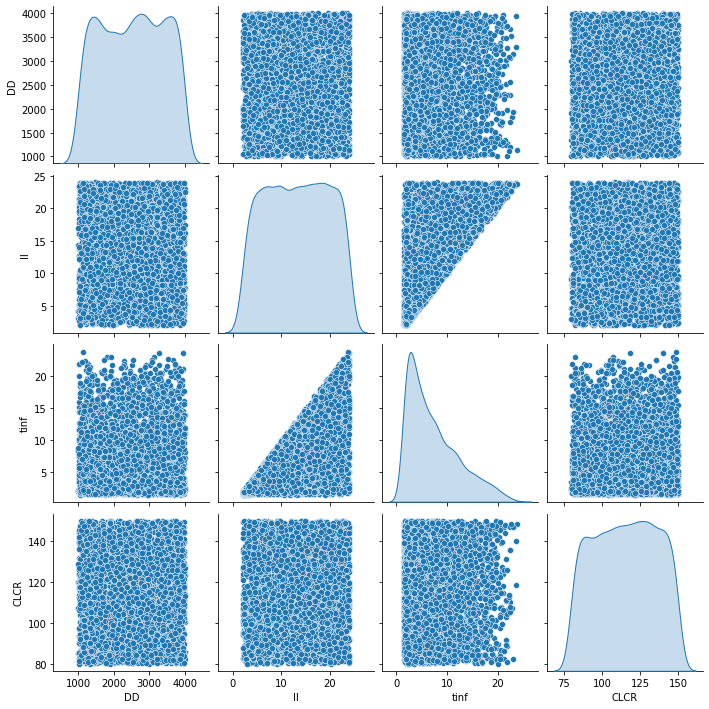

In [11]:
sns.pairplot(X_train, diag_kind='kde');

## Modelo
Ahora se especifica la configuración de la red neuronal artificial, mediante la librería `Keras`.

In [12]:
def regresorKeras():
  # Inicio de modelo
  model = tf.keras.models.Sequential([normalizer])
  # Capa de entrada
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(X_train.shape[1],)))
  # Capas ocultas
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
  # Capa de salida
  # Se seleccionan dos neuronas de salida: indicador: AUC/MIC > 400 & <600, Cmin entre 15 y 20mg/L
  # La capa de salida sólo permite valores de 0 a 1 se usa fun sigmoidea
  model.add(tf.keras.layers.Dense(2, activation = tf.nn.sigmoid)) 
  
  model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = 'mean_absolute_error')
  return model; 

In [13]:
regresorKeras().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 301
Trainable params: 292
Non-trainable params: 9
_________________________________________________________________


In [14]:
estimator = KerasRegressor(build_fn=regresorKeras, 
                           batch_size=32, epochs=60, 
                           validation_data=(X_test.values, y_test),
                           verbose=0)

history = estimator.fit(X_train.values, y_train)

In [15]:
histDF = pd.DataFrame(history.history)
histDF['epoch'] = history.epoch
histDF.tail()

,loss,val_loss,epoch
55,0.029235,0.029049,55
56,0.028903,0.029614,56
57,0.029902,0.029704,57
58,0.028770,0.029173,58
59,0.028333,0.028721,59


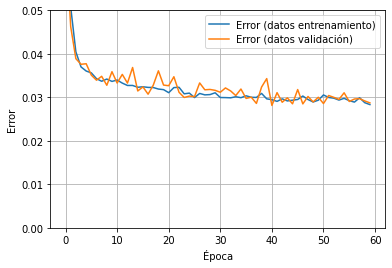

In [16]:
plt.plot(history.history['loss'], label='Error (datos entrenamiento)')
plt.plot(history.history['val_loss'], label='Error (datos validación)')
plt.ylim([0, 0.05])
plt.xlabel('Época')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.savefig('./100_Error_Entrenamiento.pdf')

In [17]:
def expand_grid(x, y, xval = 'x', yval = 'y'):
    xG, yG = np.meshgrid(x, y) # Crear malla
    xG = xG.flatten() # Hacer malla 1D
    yG = yG.flatten() # Igual
    return pd.DataFrame({xval:xG, yval:yG})

In [18]:
def PTAColorScalePlotly(color1 = 'rgb(255,32,3)', color2 = 'rgb(3,148, 252)', umbral=0.85):
  return [(0.00, color1), (umbral, color1), (umbral, color2), (1.00, color2)]

In [19]:
# sampleDF = expand_grid(np.linspace(-6, 6), np.linspace(15, 30), xval = 'MIC', yval = 'DD')
# sampleDF['ii'] = 6
# sampleDF['tinf'] = 2
# sampleDF['CLCR'] = 120
# sampleDF = sampleDF[['DD', 'ii', 'tinf', 'CLCR', 'MIC']]

In [20]:
objetoDict = {
  'DD': np.linspace(1000, 4000),
  'CLCR': np.linspace(80, 150),
  'ii': 6,
  'tinf': 2
}

ordenLista = ['DD', 'ii', 'tinf', 'CLCR']

def simularANN(variables, modelo, orden = ordenLista):
  dictArray  = [(i,k) for (i,k) in variables.items() if type(k) == np.ndarray]
  floatArray = [(i,k) for (i,k) in variables.items() if type(k) != np.ndarray]

  if len(dictArray) > 2:
    return
  
  sampleDF = expand_grid(dictArray[0][1], 
                        dictArray[1][1], 
                        xval = dictArray[0][0], 
                        yval = dictArray[1][0])

  for i in range(len(floatArray)):
    var, val = floatArray[i];
    sampleDF[var] = val

  sampleDF = sampleDF[orden]
  resultados = {'x': dictArray[0], 'y': dictArray[1], 'z': modelo.predict(sampleDF)}
  return resultados

In [21]:
DF = simularANN(objetoDict, estimator, ordenLista)

In [22]:
fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/día)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 2, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = DF['x'][1],
    y = DF['y'][1],
    z = DF['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, DF['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 1000, "end": 4000, "size": 5000, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = DF['x'][1],
    y = DF['y'][1],
    z = DF['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, DF['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q6h, tinf 2 hr')

fig.show()

fig.write_html("101_superficiePTA_dosis_MIC1.html")

overflow encountered in double_scalars
overflow encountered in double_scalars


In [23]:
def PTAColorScaleMatplotlib(color1 = "#ff2103", color2 = "#0394fc", umbral=0.85):
  cmap = ListedColormap([color1, color1, color2, color2])
  bounds = [0.0, umbral, 1.0]
  norm = BoundaryNorm(bounds, cmap.N)

  return {'cmap': cmap, 'bounds': bounds, 'norm': norm}

In [24]:
def grafico3DSuperficie(x, y, z, newcmp, xlab = '', ylab = '', zlab = '', 
                        lim_opt = {'xlab': [-6, +6], 'ylab': [1000, 4000], 'zlab': [0,1]}, 
                        view_init_opt = {'elev': 10, 'azim': 12}):
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  
  x1, y1 = np.meshgrid(x, y)

  ax.plot_surface(x1, y1, z, cmap=newcmp, linewidth=0, antialiased=False)
  ax.set_xlim(lim_opt['xlab'][0], lim_opt['xlab'][1])
  ax.set_ylim(lim_opt['ylab'][0], lim_opt['ylab'][1])
  ax.set_zlim(lim_opt['zlab'][0], lim_opt['zlab'][1])
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_zlabel(zlab)
  ax.view_init(elev = view_init_opt['elev'], azim = view_init_opt['azim']);
  return fig;

In [25]:
def grafico3DContorno(ax, x, y, z, cmap, xlab = '', ylab = '', title='', levels = [0.0, 0.85, 1.00]):
  
  x1, y1 = np.meshgrid(x, y)
  main = ax.contourf(x1, y1, z, levels = levels, cmap=cmap, 
                     #vmax=1, vmin=0
                     )
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_title(title)

  return main;

In [26]:
df = simularANN({'DD': np.linspace(1000, 4000), 'CLCR': np.linspace(80, 150), 'ii': 12, 'tinf': 4}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/día)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 2, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 1000, "end": 4000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 1000, "end": 4000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q6h, tinf 4 hrs')

fig.show()

overflow encountered in double_scalars
overflow encountered in double_scalars


In [27]:
fig.write_html("102_superficiePTA_dosis_MIC2.html")

In [28]:
df = simularANN({'DD': np.linspace(1000, 4000), 'CLCR': np.linspace(80, 150), 'ii': 12, 'tinf': 8}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/día)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 2, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 1000, "end": 4000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 1000, "end": 4000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q6h, tinf 8 hrs')

fig.show()

overflow encountered in double_scalars
overflow encountered in double_scalars


In [29]:
fig.write_html("103_superficiePTA_dosis_MIC3.html")

In [30]:
df = simularANN({'DD': np.linspace(1000, 4000), 'CLCR': np.linspace(80, 150), 'ii': 12, 'tinf': 12}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/día)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 5, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 1000, "end": 4000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 1000, "end": 4000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q12h, tinf 12 hrs')

fig.show()

overflow encountered in double_scalars
overflow encountered in double_scalars


In [31]:
fig.write_html("104_superficiePTA_dosis_MIC4.html")

In [32]:
df = simularANN({'DD': np.linspace(1000, 4000), 'CLCR': np.linspace(80, 150), 'ii': 24, 'tinf': 24}, estimator, ordenLista)

fig = make_subplots(rows=1, cols=2, 
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=("AUC 400-600", "Cmin 15-20"))

scene1 = {
    "xaxis": {"nticks": 5, 'title': 'Dosis diaria <br> (mg/día)'},
    "yaxis": {"nticks": 5, 'title': 'CLCR (mL/min/1.73m2)'},
    "zaxis": {"nticks": 5, 'range': [0, 1], 'title': 'PTA'},
    "aspectratio": {"x": 1, "y": 1, "z": 0.8},
    }

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 1000, "end": 4000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 0].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 1)
fig.update_layout(scene = scene1)

fig.add_trace(go.Surface(
    contours = {
        "y": {"show": True, "start": 80, "end": 150, "size": 1, "color":"white"},
        "x": {"show": True, "start": 1000, "end": 4000, "size": 500, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = df['x'][1],
    y = df['y'][1],
    z = df['z'][:, 1].reshape((50, 50)),
    cmin=0.0, cmax=1.0,
    customdata = [i for i in map(lambda m: 2**m, df['x'][1])],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = PTAColorScalePlotly()
    ), row = 1, col = 2)

fig.update_layout(scene2 = scene1)
fig.update_layout(title_text = 'Superficie de Respuesta - VAN II q24h, tinf 24 hrs')

fig.show()

overflow encountered in double_scalars
overflow encountered in double_scalars


In [33]:
fig.write_html("105_superficiePTA_dosis_MIC5.html")

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


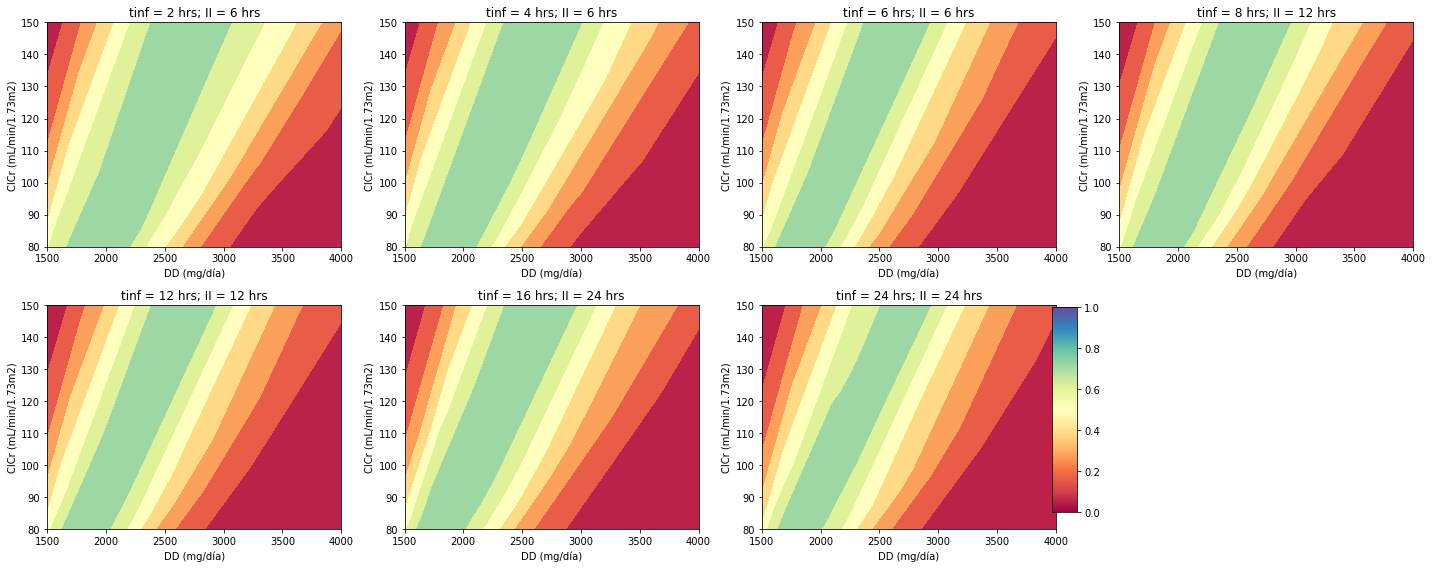

In [34]:
fig = plt.figure(figsize=(20,8), constrained_layout=True)

colscal = PTAColorScaleMatplotlib(umbral=0.85)

tinf_c = [2, 4, 6, 8, 12, 16, 24]
ii_c   = [6, 6, 6, 12, 12,24, 24]
n = 500
# Cambio de la dosis diaria
for i, (j, k) in enumerate( zip( tinf_c, ii_c )):
  ax = plt.subplot(2,4, i+1)

  df = simularANN({'DD': np.linspace(1500, 4000, n), 'CLCR': np.linspace(80, 150, n), 'ii': k, 'tinf': j}, estimator, ordenLista)

  grafico3DContorno(ax, df['x'][1], df['y'][1], df['z'][:, 0].reshape((n,n)), plt.get_cmap('Spectral'),
                    'DD (mg/día)', 'ClCr (mL/min/1.73m2)', 'tinf = {0} hrs; II = {1} hrs'.format(j, k), 
                    levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
  # ax[i].vlines(0, 90, 150, linestyle='dashed')

#plt.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('magma')));
fig.colorbar(cm.ScalarMappable(cmap='Spectral'), ax = ax, location='right', shrink=0.8, panchor = (0.0, 1.5));
fig.set_tight_layout(True)

#fig.suptitle('PTA - Objetivo AUC (400, 600 mg*h/L)\n', va = 'bottom', size=15); 
fig.savefig('106_superficiePTA_CLCR_DD_PTA1.pdf', bbox_inches='tight')
#files.download('/content/106_superficiePTA_CLCR_DD_PTA1.pdf')

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


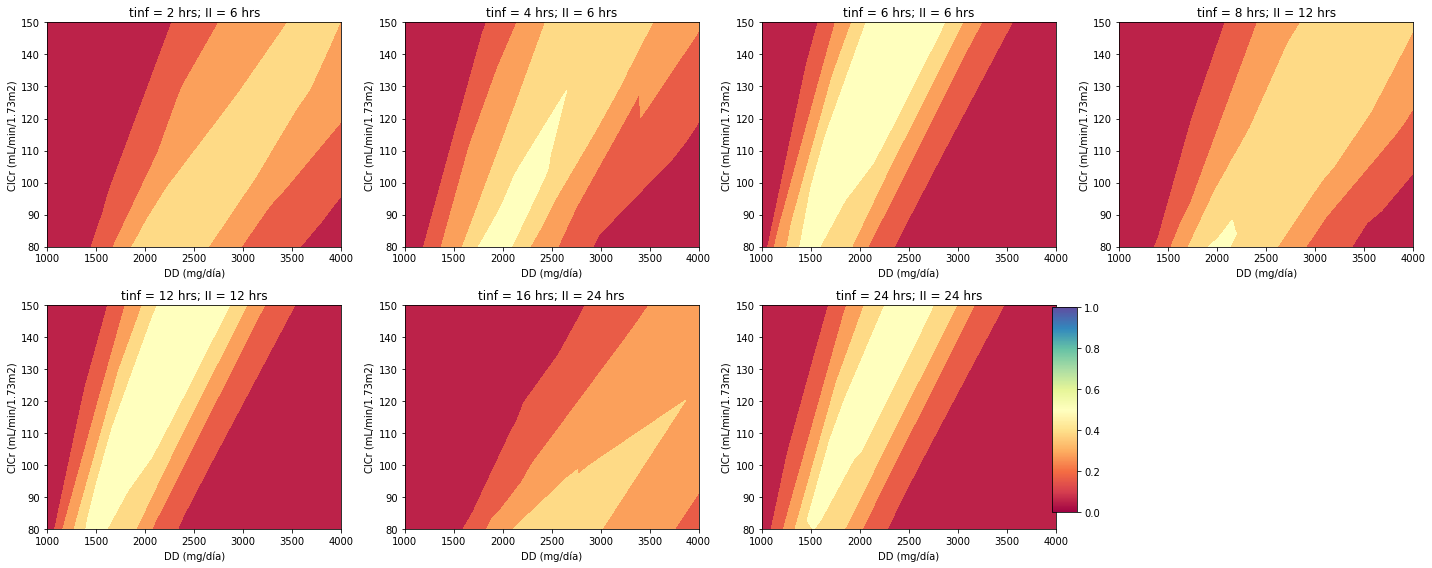

In [35]:
fig = plt.figure(figsize=(20,8), constrained_layout=True)

colscal = PTAColorScaleMatplotlib(umbral=0.85)

tinf_c = [2, 4, 6, 8, 12, 16, 24]
ii_c   = [6, 6, 6, 12, 12,24, 24]
n = 500

# Cambio de la dosis diaria
for i, (j, k) in enumerate(zip(tinf_c, ii_c)):
  ax = plt.subplot(2,4, i+1)
  
  df = simularANN({'DD': np.linspace(1000, 4000, n), 'CLCR': np.linspace(80, 150, n), 'ii': k, 'tinf': j}, estimator, ordenLista)

  grafico3DContorno(ax, df['x'][1], df['y'][1], df['z'][:, 1].reshape((n,n)), plt.get_cmap('Spectral'),
                    'DD (mg/día)', 'ClCr (mL/min/1.73m2)', 'tinf = {0} hrs; II = {1} hrs'.format(j, k), 
                    levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
  # ax[i].vlines(0, 90, 150, linestyle='dashed')

fig.colorbar(cm.ScalarMappable(cmap=plt.get_cmap('Spectral')), location='right', shrink=0.8, panchor = (0.0, 1.5));
fig.set_tight_layout(True)

#fig.suptitle('PTA - Objetivo Cmin (15, 20 mg/L)\n', va = 'bottom', size=15); 
fig.savefig('107_superficiePTA_CLCR_DD_PTA2.pdf', bbox_inches='tight') 
#files.download('/content/107_superficiePTA_CLCR_DD_PTA2.pdf')

In [36]:
from google.colab import files

files_to_download = [
  "/content/100_Error_Entrenamiento.pdf",
  "/content/101_superficiePTA_dosis_MIC1.html",
  "/content/102_superficiePTA_dosis_MIC2.html",
  "/content/103_superficiePTA_dosis_MIC3.html",
  "/content/104_superficiePTA_dosis_MIC4.html",
  "/content/105_superficiePTA_dosis_MIC5.html",
  "/content/106_superficiePTA_CLCR_DD_PTA1.pdf",
  "/content/107_superficiePTA_CLCR_DD_PTA2.pdf"
 ]

[files.download(i) for i in files_to_download]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[None, None, None, None, None, None, None, None]

## Explicación de importancia de predictores

In [37]:
perm = PermutationImportance(estimator, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.1465 ± 0.0025,DD
0.0859 ± 0.0020,II
0.0566 ± 0.0012,CLCR
0.0401 ± 0.0007,tinf


In [38]:
# Toca extraer el modelo del wrapper de Scikit
explainer = shap.KernelExplainer(model = estimator.model.predict, data = X_train.iloc[0:50, :], link = "identity")

In [39]:
X_idx = 0
shap_value_single = explainer.shap_values(X = X_train.iloc[X_idx:X_idx+1,:], nsamples = 100)
shap_value_single

[array([[-0.17988013,  0.03619742, -0.02941479, -0.06358622]]),
 array([[-0.03278927,  0.01306935, -0.08397187, -0.00627521]])]

In [40]:
X_muestra = X_train.sample(100)
shap_values = explainer.shap_values(X = X_muestra, nsamples = 100)

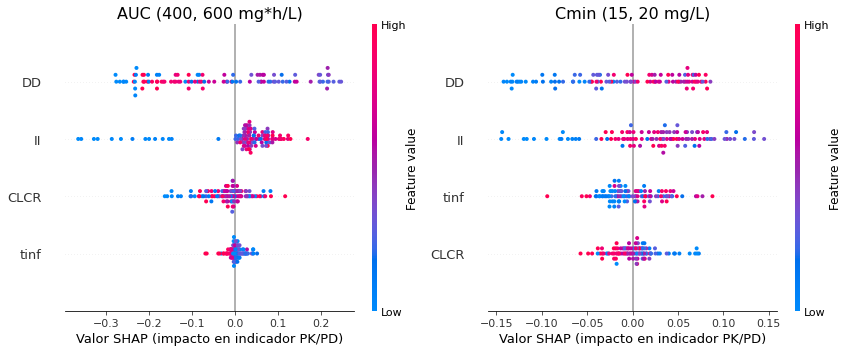

In [41]:
list_titulos = ['AUC (400, 600 mg*h/L)', 'Cmin (15, 20 mg/L)']

fig = plt.figure(figsize=(12, 5))
for i in range(2):
  plt.subplot(1,2,i+1)
  shap.summary_plot(shap_values = shap_values[i], features = X_muestra, show=False, plot_size=None, sort=True)
  ax = plt.gca()
  ax.set_xlabel('Valor SHAP (impacto en indicador PK/PD)')
  ax.set_title(list_titulos[i], fontdict={"size": 16})
fig.set_tight_layout(True)

plt.savefig('108_shapValuesPTA_AUCMIC.pdf')

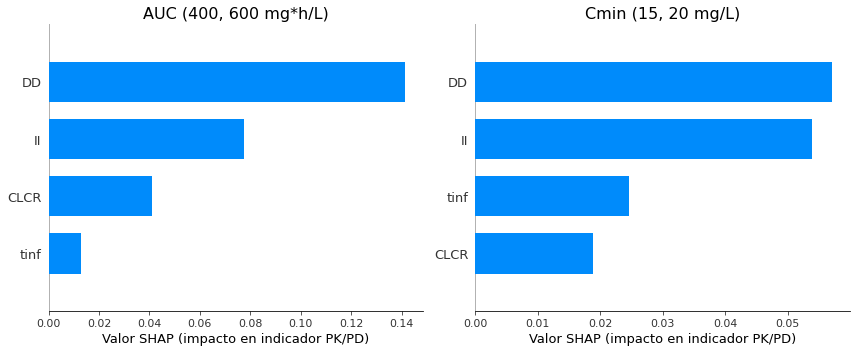

In [42]:
list_titulos = ['AUC (400, 600 mg*h/L)', 'Cmin (15, 20 mg/L)']

fig = plt.figure(figsize=(12, 5))
for i in range(2):
  plt.subplot(1,2,i+1)
  shap.summary_plot(shap_values = shap_values[i], features = X_muestra, show=False, 
                    plot_size=None, sort=True, plot_type="bar")
  ax = plt.gca()
  ax.set_xlabel('Valor SHAP (impacto en indicador PK/PD)')
  ax.set_title(list_titulos[i], fontdict={"size": 16})
fig.set_tight_layout(True)

plt.savefig('109_shapValuesPTA_AUCMIC.pdf')

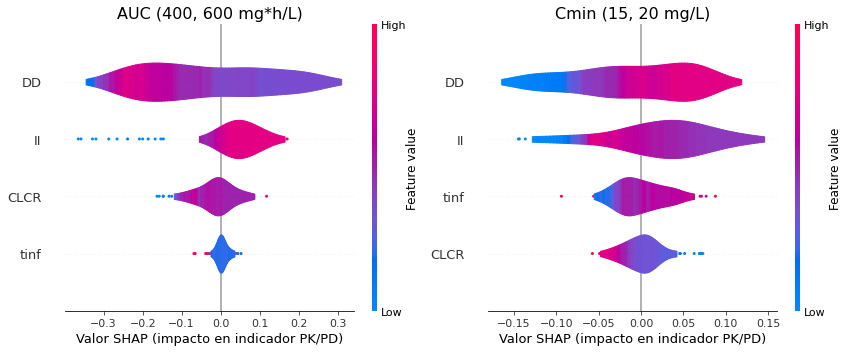

In [43]:
list_titulos = ['AUC (400, 600 mg*h/L)', 'Cmin (15, 20 mg/L)']

fig = plt.figure(figsize=(12, 5))
for i in range(2):
  plt.subplot(1,2,i+1)
  shap.summary_plot(shap_values = shap_values[i], features = X_muestra, show=False, 
                    plot_size=None, sort=True, plot_type="violin")
  ax = plt.gca()
  ax.set_xlabel('Valor SHAP (impacto en indicador PK/PD)')
  ax.set_title(list_titulos[i], fontdict={"size": 16})
fig.set_tight_layout(True)

plt.savefig('110_shapValuesPTA_AUCMIC.pdf')

In [44]:
shap.plots.initjs()
shap.force_plot(0, shap_values[0], 
                feature_names=['DD', 'II', 'tinf', 'CLCR'])

In [45]:
from google.colab import files

files_to_download = [
  "/content/108_shapValuesPTA_AUCMIC.pdf",
  "/content/109_shapValuesPTA_AUCMIC.pdf",
  "/content/110_shapValuesPTA_AUCMIC.pdf"
 ]

[files.download(i) for i in files_to_download]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[None, None, None]

In [46]:
X_todos = X_train.copy()
X_todos['AUC']  = [i for i, _ in estimator.predict(X_train)]
X_todos['Cmin'] = [j for _, j in estimator.predict(X_train)]
X_todos

,DD,II,tinf,CLCR,AUC,Cmin
4227,3443.520108,17.032405,16.563722,93.122852,0.034872,1.346466e-02
4676,2789.452798,5.720762,1.594745,145.287225,0.604043,6.589335e-02
800,1525.923430,13.877228,1.594198,118.725491,0.184807,2.478600e-03
3671,3010.154944,2.706269,1.949802,122.868290,0.000003,1.344468e-14
4193,3421.789712,15.282308,7.206488,128.626320,0.206507,2.887790e-01
...,...,...,...,...,...,...
4426,1668.181753,5.231285,4.537101,126.466981,0.053976,8.743703e-04
466,3803.755500,10.009449,7.773788,130.871842,0.087549,1.714859e-01
3092,2674.569026,18.203360,16.727062,144.299721,0.660858,3.859627e-01
3772,3953.366084,13.085584,2.090959,105.546480,0.015444,2.664575e-01


In [47]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

label_dict = {'x': 'PTA AUC (400-600 mg*h/L)', 'y': 'PTA Cmin (15-20 mg/L)'}

fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.5, 0.5],
    row_heights=[0.5, 0.5],
    x_title = label_dict['x'],
    y_title = label_dict['y'],
    specs=[[{"type": "scatter"}, {"type": "scatter"}],
           [{"type": "scatter"}, {"type": "scatter"}]])

fig.add_trace(
    go.Scatter(x = X_todos['AUC'], y = X_todos["Cmin"], mode = 'markers', 
               marker = {'color': X_todos['DD']}, name='DD'),row = 1, col = 1)

fig.add_trace(
    go.Scatter(x = X_todos['AUC'], y = X_todos["Cmin"], mode = 'markers', 
               marker = {'color': X_todos['II']}, name='II'), row = 1, col = 2)
fig.add_trace(
    go.Scatter(x = X_todos['AUC'], y = X_todos["Cmin"], mode = 'markers', 
               marker = {'color': X_todos['tinf']}, name='Tinf'), row = 2, col = 1)
fig.add_trace(
    go.Scatter(x = X_todos['AUC'], y = X_todos["Cmin"], mode = 'markers', 
               marker = {'color': X_todos['CLCR']}, name='CLCR'), row = 2, col = 2)

for i in range(2):
  for j in range(2):
    fig.update_xaxes(range=[0.0, 0.7], row=i, col=j)
    fig.update_yaxes(range=[0.0, 0.7], row=i, col=j)

fig.write_html("111_ComparativoIndicadoresPKPD.html")
files.download('/content/111_ComparativoIndicadoresPKPD.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>